**Brain Tumor Classification with CNN**

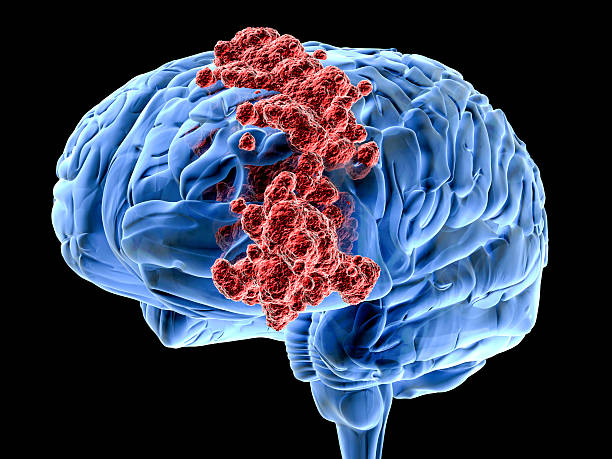

# *Libraries*


In [56]:
import numpy as np 
import pandas as pd
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Conv2D,Dropout
from tensorflow.keras.activations import relu,softmax,tanh
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing import image_dataset_from_directory
from glob import glob
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,MaxPool2D
from keras import regularizers
from keras import optimizers
from keras import metrics
from sklearn.metrics import confusion_matrix
import itertools
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# *Load Data*



In [3]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [4]:
X_train = []
Y_train  = []
X_test = []
Y_test = []

In [5]:
image_size=150
for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/Colab Notebooks/CNN/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)
    
X_train = np.array(X_train)

100%|██████████| 827/827 [00:06<00:00, 135.74it/s]


In [6]:
for label in labels:
  
    testPath = os.path.join('/content/drive/MyDrive/Colab Notebooks/CNN/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)
    
X_test = np.array(X_test)

100%|██████████| 82/82 [00:00<00:00, 94.34it/s]


# *Data Visualaization*

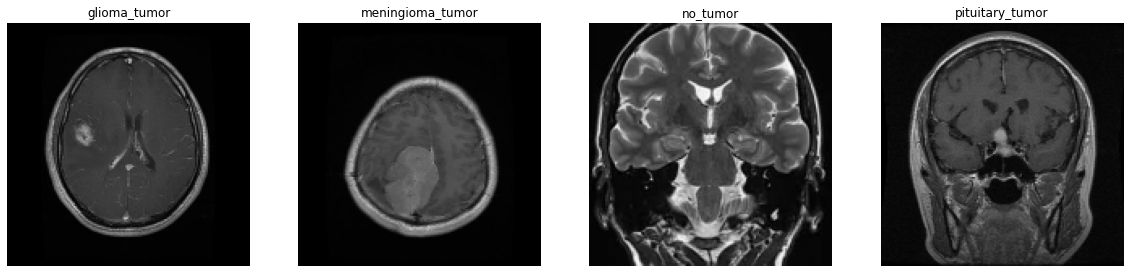

In [7]:
fig, ax = plt.subplots(1,4, figsize=(20,20))
k = 0
for i in range(0,4):
    if i==0: idx=0
    elif i==1: idx=827
    elif i==2: idx=1649
    else: idx=2045
    ax[k].imshow(X_train[idx])
    ax[k].set_title(Y_train[idx])
    ax[k].axis('off')
    k+=1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


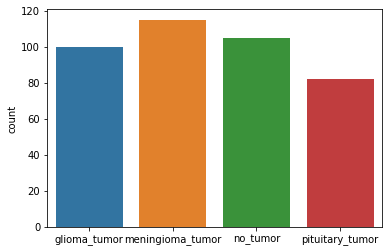

In [8]:
sns.countplot(Y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


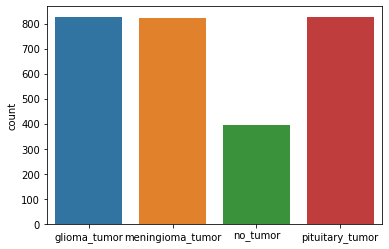

In [9]:
sns.countplot(Y_train)

# *Split Data*

In [10]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=28)


In [11]:
y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=28)


# *Model*

In [18]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs = base_model.input, outputs=model)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])



datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=True,  
        vertical_flip=False)  


In [19]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet152v1.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)


In [22]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
                              validation_data=(X_val, Y_val), 
                              epochs=10, 
                              verbose=1,
                            callbacks=[tensorboard, checkpoint, reduce_lr])


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/10
72/72 [==============================] - 265s 4s/step - loss: 0.1519 - accuracy: 0.9460 - val_loss: 2.0306 - val_accuracy: 0.6568

Epoch 00001: val_accuracy did not improve from 0.86063
Epoch 2/10
72/72 [==============================] - 272s 4s/step - loss: 0.1020 - accuracy: 0.9625 - val_loss: 0.7002 - val_accuracy: 0.8746

Epoch 00002: val_accuracy improved from 0.86063 to 0.87456, saving model to resnet152v1.h5
Epoch 3/10
72/72 [==============================] - 270s 4s/step - loss: 0.1076 - accuracy: 0.9682 - val_loss: 0.6364 - val_accuracy: 0.8240

Epoch 00003: val_accuracy did not improve from 0.87456
Epoch 4/10
72/72 [==============================] - 269s 4s/step - loss: 0.0496 - accuracy: 0.9848 - val_loss: 0.5977 - val_accuracy: 0.8310

Epoch 00004: val_accuracy did not improve from 0.87456

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 5/10
72/72 [==============================] - 269s 4s/step - loss: 0.0288 - accuracy: 0.9

# *Plot Results*

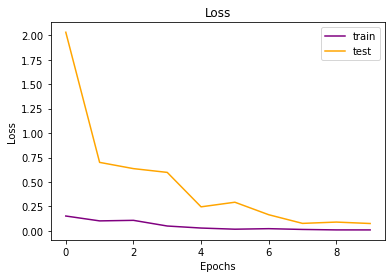

In [23]:
plt.plot(history.history["loss"],c = "purple")
plt.plot(history.history["val_loss"],c = "orange")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

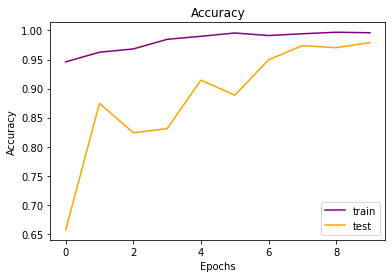

In [24]:
plt.plot(history.history["accuracy"],c = "purple")
plt.plot(history.history["val_accuracy"],c = "orange")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

# *Predict*

In [25]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [34]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [35]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])